### Переходим к практике

In [1]:
import pandas as pd

Наши новости

In [3]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [4]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [5]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

/home/aleksandr/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [6]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [7]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [8]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [9]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [10]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-9-7ee348d9b386>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


CPU times: user 44.9 s, sys: 1.88 s, total: 46.8 s
Wall time: 46.9 s


In [11]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 6min 35s, sys: 1.72 s, total: 6min 36s
Wall time: 6min 41s


А теперь в 3 строчки обучим нашу модель

In [12]:
news['title']

0        [заместитель, председатель, правительство, рф,...
1        [матч, финал, кубок, россия, футбол, приостано...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, xx, в...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, тропический, углеродный, цикл, чув...
26999    [жить, примерно, тыс, назад, территория, совре...
Name: title, Length: 27000, dtype: object

In [13]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Запускаем обучение

In [16]:
from gensim.models import LdaModel

In [17]:
LdaModel?

In [18]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

CPU times: user 3min 9s, sys: 6.63 s, total: 3min 15s
Wall time: 1min 23s


In [19]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [20]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(2, 0.05067586),
 (8, 0.1109696),
 (11, 0.52301145),
 (14, 0.11657911),
 (15, 0.17758761)]

In [21]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: физика офицер диск гражданство австралийский террорист боевик
topic_1: путин российский граница россия турция владимир государство
topic_2: статья тыс площадь рейс общество установить москва
topic_3: препарат обнаружить связанный торговый сотрудник организм ребёнок
topic_4: земля произойти тело взрыв день первый км
topic_5: власть рф россия nn правительство данные глава
topic_6: египет белоруссия белорусский конструкция саммит аналог минск
topic_7: погибнуть конкурс сократиться супруг корея знаменитый японский
topic_8: украина украинский мозг писать женщина всё день
topic_9: россия военный сша российский американский гражданин пациент
topic_10: эксперимент экипаж производитель чиновник управление дональд испытание
topic_11: цена новый nn большой жизнь рост банк
topic_12: рынок развитие государство поверхность управление проверка метод
topic_13: млрд исследование млн рубль объём доход россия
topic_14: восток участок гражданин торговый тур фронт задолженность
topic_15: наука всё

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [22]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [23]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.0,0.000000,0.0,0.000000,0.893171,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.010697,0.0,0.0,0.0,0.0
1,4896,0.0,0.0,0.000000,0.0,0.747747,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,4897,0.0,0.0,0.050684,0.0,0.000000,0.000000,0.0,0.0,0.110952,...,0.177448,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,4898,0.0,0.0,0.000000,0.0,0.051476,0.000000,0.0,0.0,0.000000,...,0.795197,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,4899,0.0,0.0,0.000000,0.0,0.035453,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.509466,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [24]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [25]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [26]:
doc_dict[293622]

array([0.        , 0.09208531, 0.        , 0.0290725 , 0.09520885,
       0.04680189, 0.01914208, 0.02102103, 0.        , 0.03261912,
       0.        , 0.25717428, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.24558359, 0.10787089, 0.        ,
       0.04391419, 0.        , 0.        , 0.        , 0.        ])

# задание 2


In [27]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list, agg):
    funcs = {'mean': np.mean,
            'max': np.max,
            'median': np.median}
    func = funcs.get(agg)
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = func(user_vector, 0)
    return user_vector

In [28]:
get_user_embedding(user_articles_list, 'mean')

array([0.00424347, 0.10292851, 0.03995337, 0.00715814, 0.00250542,
       0.22171143, 0.        , 0.00562884, 0.0425036 , 0.11398923,
       0.01691396, 0.04646917, 0.01971166, 0.04411369, 0.        ,
       0.04204608, 0.00187555, 0.03478836, 0.16092161, 0.01242071,
       0.        , 0.02323017, 0.        , 0.00628474, 0.0386678 ])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [29]:
#users['articles'].iloc[33]

In [30]:
#" ".join(news[news['doc_id']==323186]['title'].iloc[0])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [31]:
def get_user_embeddings():
    result = list()
    for agg in ['mean', 'max', 'median']:
        user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, agg), 1)])
        user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
        user_embeddings['uid'] = users['uid'].values
        user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
        result.append(user_embeddings)
    return result

In [32]:
user_embeddings = get_user_embeddings()

user_embeddings_mean = user_embeddings[0]
user_embeddings_max = user_embeddings[1]
user_embeddings_median = user_embeddings[2]

In [33]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, 'mean'), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.015348,0.187299,0.031297,0.063783,0.104689,0.003190,0.014514,0.117917,...,0.002903,0.000000,0.136058,0.063844,0.012998,0.045382,0.000000,0.002511,0.0,0.005088
1,u108690,0.0,0.055766,0.039073,0.010371,0.018662,0.130253,0.002224,0.002918,0.168016,...,0.036034,0.001919,0.160064,0.099765,0.001842,0.010125,0.029108,0.008682,0.0,0.026404
2,u108339,0.0,0.011032,0.063651,0.026086,0.073762,0.203430,0.001837,0.005825,0.080006,...,0.003714,0.042627,0.078113,0.111469,0.002698,0.023573,0.032058,0.012781,0.0,0.014014


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [34]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [35]:
X_mean = pd.merge(user_embeddings_mean, target, 'left')
X_max = pd.merge(user_embeddings_max, target, 'left')
X_median = pd.merge(user_embeddings_median, target, 'left')
X_mean.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.015348,0.187299,0.031297,0.063783,0.104689,0.003190,0.014514,0.117917,...,0.000000,0.136058,0.063844,0.012998,0.045382,0.000000,0.002511,0.0,0.005088,0
1,u108690,0.0,0.055766,0.039073,0.010371,0.018662,0.130253,0.002224,0.002918,0.168016,...,0.001919,0.160064,0.099765,0.001842,0.010125,0.029108,0.008682,0.0,0.026404,1
2,u108339,0.0,0.011032,0.063651,0.026086,0.073762,0.203430,0.001837,0.005825,0.080006,...,0.042627,0.078113,0.111469,0.002698,0.023573,0.032058,0.012781,0.0,0.014014,1


In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [41]:
#разделим данные на train/test
X_train_mean, X_test_mean, y_train, y_test = train_test_split(X_mean[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_mean['churn'], random_state=0)

X_train_max, X_test_max, y_train, y_test = train_test_split(X_max[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_max['churn'], random_state=0)

X_train_median, X_test_median, y_train, y_test = train_test_split(X_median[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_median['churn'], random_state=0)

In [42]:
logreg_mean = LogisticRegression()
#обучим 
logreg_mean.fit(X_train_mean, y_train)

logreg_max = LogisticRegression()
#обучим 
logreg_max.fit(X_train_max, y_train)

logreg_median = LogisticRegression()
#обучим 
logreg_median.fit(X_train_median, y_train)

LogisticRegression()

In [43]:
#наши прогнозы для тестовой выборки
preds_mean = logreg_mean.predict_proba(X_test_mean)[:, 1]
preds_max = logreg_max.predict_proba(X_test_max)[:, 1]
preds_median = logreg_median.predict_proba(X_test_median)[:, 1]

In [44]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [45]:
import itertools

# задание 5

In [46]:
precision_mean, recall_mean, thresholds_mean = precision_recall_curve(y_test, preds_mean)
fscore_mean = (2 * precision_mean * recall_mean) / (precision_mean + recall_mean)
# locate the index of the largest f score
ix = np.argmax(fscore_mean)
print('Best Threshold_mean=%f, F-Score_mean=%.3f, Precision_mean=%.3f, Recall_mean=%.3f' % (thresholds_mean[ix], 
                                                                        fscore_mean[ix],
                                                                        precision_mean[ix],
                                                                        recall_mean[ix]))

precision_max, recall_max, thresholds_max = precision_recall_curve(y_test, preds_max)
fscore_max = (2 * precision_max * recall_max) / (precision_max + recall_max)
# locate the index of the largest f score
ix = np.argmax(fscore_max)
print('Best Threshold_max=%f, F-Score_max=%.3f, Precision_max=%.3f, Recall_max=%.3f' % (thresholds_max[ix], 
                                                                        fscore_max[ix],
                                                                        precision_max[ix],
                                                                        recall_max[ix]))

precision_median, recall_median, thresholds_median = precision_recall_curve(y_test, preds_median)
fscore_median = (2 * precision_median * recall_median) / (precision_median + recall_median)
# locate the index of the largest f score
ix = np.argmax(fscore_median)
print('Best Threshold_median=%f, F-Score_median=%.3f, Precision_median=%.3f, Recall_median=%.3f' % (thresholds_median[ix], 
                                                                        fscore_median[ix],
                                                                        precision_median[ix],
                                                                        recall_median[ix]))

Best Threshold_mean=0.216328, F-Score_mean=0.725, Precision_mean=0.620, Recall_mean=0.873
Best Threshold_max=0.399916, F-Score_max=0.837, Precision_max=0.872, Recall_max=0.804
Best Threshold_median=0.267345, F-Score_median=0.844, Precision_median=0.819, Recall_median=0.869


In [47]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1708   47]
 [  33  212]]


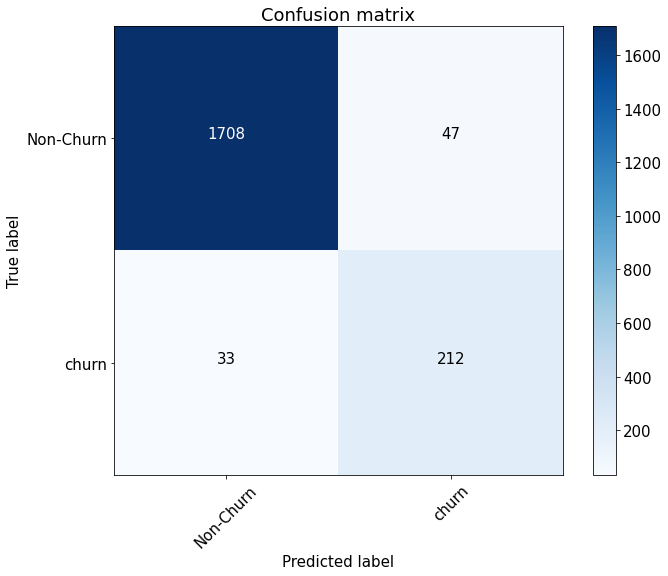

In [51]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_median>thresholds_median[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [52]:
roc_auc_score(y_test, preds_median)

0.9836502122216408

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

#### Ссылки

1. http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf
2. https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

#### Библиотеки, которые нужно установить:

1. gensim
2. razdel
3. pymorphy2
4. nltk

#### Дополнительно, библиотеки для анализа текста
1. spacy 
2. natasha
3. nltk